<a href="https://colab.research.google.com/github/mohammadabid-macad/AIAStudioG03/blob/main/Camden_HeightPrediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Install Dependencies

In [1]:
!pip install numpy pandas tensorflow scikit-learn


# Step 2: Import Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


# Step 3: Load the Pickle File

In [3]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Load the pickle file
pickle_path = '/content/drive/MyDrive/Camden/buildings_with_materials.pkl'
buildings_with_materials = pd.read_pickle(pickle_path)

# Display the loaded DataFrame
buildings_with_materials.head()


name     Category             Sub-Cat  \
element_type osmid                                              
way          963216394   NaN  residential          apartments   
             108339905   NaN  residential               house   
             201627344   NaN  residential         residential   
             1018227525  NaN  residential  semidetached_house   
             973557352   NaN  residential          apartments   

                                                             centroid  \
element_type osmid                                                      
way          963216394   POINT (525284.0765409454 185249.51613316324)   
             108339905    POINT (529106.2080625149 185307.8073744377)   
             201627344   POINT (525859.0254776309 184485.59254876326)   
             1018227525   POINT (525675.895791421 185150.00921687827)   
             973557352   POINT (529560.6032604633 185101.85786368023)   

                                                              geo_polygons  \
element_type osmid                                                           
way          963216394   POLYGON ((525328.340 185247.149, 525328.066 18...   
             108339905   POLYGON ((529110.078 185314.550, 529108.930 18...   
             201627344   POLYGON ((525864.721 184491.302, 525860.215 18...   
             1018227525  POLYGON ((525667.364 185151.659, 525683.365 18...   
             973557352   POLYGON ((529567.733 185108.155, 529568.627 18...   

                                                                     nodes  \
element_type osmid                                                           
way          963216394   [8909859680, 8909859681, 8909859682, 890985968...   
             108339905   [1243325677, 9006963338, 9006963339, 124332567...   
             201627344   [2116543321, 2116543316, 2116543404, 211654340...   
             1018227525  [9391653806, 9391653807, 9391653808, 939165380...   
             973557352   [9010413289, 9010413288, 9010413287, 901041328...   

                         building:levels building:material addr:postcode  \
element_type osmid                                                         
way          963216394               4.0               NaN           NaN   
             108339905               3.0               NaN           NaN   
             201627344               4.0               NaN           NaN   
             1018227525              2.0               NaN           NaN   
             973557352               2.0               NaN           NaN   

                        roof:levels  ...      wood brick_area ceramic_area  \
element_type osmid                   ...                                     
way          963216394          NaN  ...  0.010217   0.628293     0.468957   
             108339905            0  ...  0.000107   0.000195     0.002101   
             201627344          NaN  ...  0.001824   0.006898     0.131159   
             1018227525         NaN  ...  0.000001   0.000010     0.000159   
             973557352            0  ...  0.027003   0.498540     0.039593   

                         glass_area    metal_area  painted_area  stone_area  \
element_type osmid                                                            
way          963216394     0.010639  4.324057e-08  1.495512e-04    0.983602   
             108339905     0.003007  8.929914e-10  2.276669e-06    0.007007   
             201627344     0.011934  3.116285e-08  2.139399e-04    0.068209   
             1018227525    0.000320  7.008148e-13  9.348241e-09    0.000949   
             973557352     0.092510  1.074439e-04  3.197237e-03    0.902308   

                            tile_area  wood_area  camera_distance  
element_type osmid                                                 
way          963216394   5.138711e-02   0.128472         0.000152  
             108339905   4.201987e-05   0.000328         0.000173  
             201627344   2.914731e-03   0.011196        

In [5]:
buildings_with_materials.shape

(910, 44)

# Step 4: Prepare the Data

In [ ]:
# prompt: in the buildings_with_materials create a column called 'Building_Height' which multiplies the building levels to 3 (our floor to floor height)

buildings_with_materials['Building_Heights'] = buildings_with_materials['building:levels'] * 3


In [7]:
buildings_with_materials.columns

Index(['name', 'Category', 'Sub-Cat', 'centroid', 'geo_polygons', 'nodes',
       'building:levels', 'building:material', 'addr:postcode', 'roof:levels',
       'roof:shape', 'building:colour', 'roof:colour', 'latitude', 'longitude',
       'edges', 'facade_edge_length', 'total_edge_length',
       'Building_FootprintArea', 'facade_area', 'bbox', 'bbox_center',
       'metadata_info', 'image_url', 'brick', 'ceramic', 'foliage', 'glass',
       'metal', 'painted', 'sky', 'stone', 'tile', 'water', 'wood',
       'brick_area', 'ceramic_area', 'glass_area', 'metal_area',
       'painted_area', 'stone_area', 'tile_area', 'wood_area',
       'camera_distance'],
      dtype='object')

### Cell 1: Feature Selection and One-Hot Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Select relevant features
features = buildings_with_materials[['Category', 'facade_area', 'Building_FootprintArea', 'camera_distance',
                                     'latitude', 'longitude', 'brick', 'ceramic',
                                     'glass', 'metal', 'painted', 'stone', 'tile', 'wood']]
target = buildings_with_materials['Building_Heights']

# One-hot encode the 'Category' feature
encoder = OneHotEncoder()
category_encoded = encoder.fit_transform(features[['Category']]).toarray()
category_encoded_df = pd.DataFrame(category_encoded, columns=encoder.get_feature_names_out(['Category']))

# Drop original 'Category' column and concatenate encoded columns
features = features.drop(columns=['Category']).reset_index(drop=True)
features = pd.concat([features, category_encoded_df], axis=1)

# Normalize material percentage columns (ensure they are already numeric)
material_columns = ['brick', 'ceramic', 'glass', 'metal', 'painted', 'stone', 'tile', 'wood']
for col in material_columns:
    features[col] = features[col].astype('float') / 100

# Reset index of both DataFrames
features.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

# Combine features and target into a single DataFrame for correlation analysis
data_for_corr = features.copy()
data_for_corr['Building_Heights'] = target

# Display the updated DataFrame
data_for_corr.head()


,facade_area,Building_FootprintArea,camera_distance,latitude,longitude,brick,ceramic,glass,metal,painted,...,Category_commercial,Category_education,Category_hospitality,Category_industrial,Category_institution,Category_office,Category_residential,Category_retail,Category_nan,Building_Heights
0,1257.420520,1316.835860,0.000152,51.552241,-0.194368,4.996680e-04,3.729518e-04,0.000008,3.438831e-11,1.189349e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0
1,307.880837,93.465550,0.000173,51.551886,-0.139281,6.325341e-07,6.822892e-06,0.000010,2.900445e-12,7.394644e-09,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0
2,613.861660,224.112254,0.000202,51.545244,-0.186379,1.123777e-05,2.136629e-04,0.000019,5.076526e-11,3.485148e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0
3,228.358503,116.142296,0.000268,51.551251,-0.188786,4.193369e-08,6.972052e-07,0.000001,3.068924e-15,4.093669e-11,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0
4,276.740103,90.739994,0.000072,51.549941,-0.132808,1.801473e-03,1.430686e-04,0.000334,3.882485e-07,1.155321e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0


### Cell 2: Plot Correlation Matrix

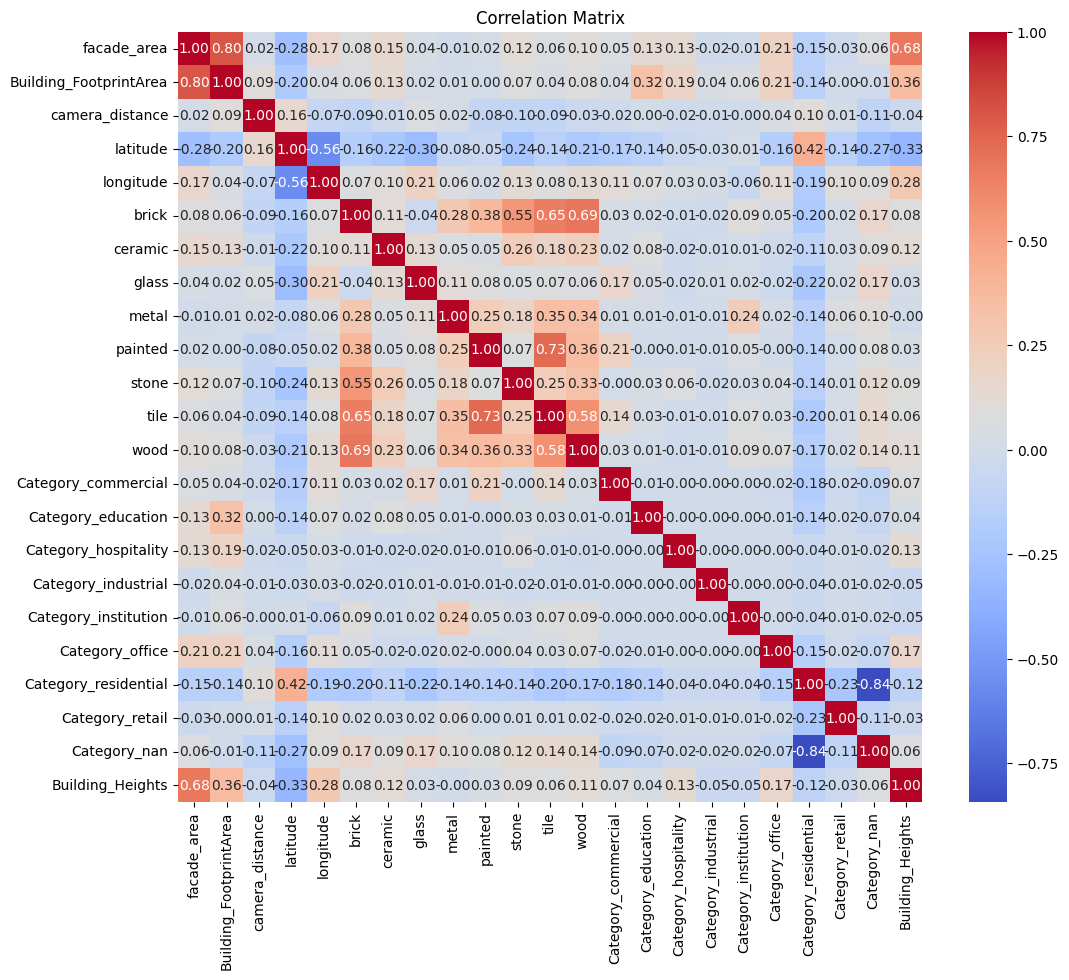

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data_for_corr.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


### Cell 3: Normalize Features and Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler_features = StandardScaler()
features_normalized = scaler_features.fit_transform(features)

# Normalize target separately
scaler_target = StandardScaler()
target_normalized = scaler_target.fit_transform(target.values.reshape(-1, 1)).flatten()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target_normalized, test_size=0.2, random_state=42)

# Display shapes of the train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((728, 22), (182, 22), (728,), (182,))

### Cell 4: Define and Compile the ANN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the ANN model with adjusted dropout rates
model = Sequential()
n_cols = X_train.shape[1]

model.add(Dense(64, input_shape=(n_cols,), activation='relu'))
model.add(Dropout(0.3))  # Adjusted dropout rate
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # Adjusted dropout rate
model.add(Dense(1, activation='linear'))

# Compile the model with a different learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Display the model summary
model.summary()

# Early stopping callback with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1472      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3585 (14.00 KB)
Trainable params: 3585 (14.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Cell 5: Train the Model

In [ ]:
# Train the model with early stopping and increased epochs
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32, callbacks=[early_stopping])


Epoch 1/200
19/19 [==============================] - 4s 58ms/step - loss: 1.7566 - val_loss: 0.5875
Epoch 2/200
19/19 [==============================] - 0s 18ms/step - loss: 1.1649 - val_loss: 0.4918
Epoch 3/200
19/19 [==============================] - 0s 15ms/step - loss: 1.1886 - val_loss: 0.4658
Epoch 4/200
19/19 [==============================] - 0s 18ms/step - loss: 0.8639 - val_loss: 0.4443
Epoch 5/200
19/19 [==============================] - 0s 15ms/step - loss: 0.7944 - val_loss: 0.4185
Epoch 6/200
19/19 [==============================] - 0s 11ms/step - loss: 0.8395 - val_loss: 0.4223
Epoch 7/200
19/19 [==============================] - 0s 13ms/step - loss: 0.7866 - val_loss: 0.4169
Epoch 8/200
19/19 [==============================] - 0s 10ms/step - loss: 0.7701 - val_loss: 0.4072
Epoch 9/200
19/19 [==============================] - 0s 12ms/step - loss: 0.8063 - val_loss: 0.3958
Epoch 10/200
19/19 [==============================] - 0s 12ms/step - loss: 0.7602 - val_loss: 0.3963

### Cell 6: Evaluate the Model

6/6 [==============================] - 0s 5ms/step - loss: 1.0430
Mean Squared Error: 1.0429655313491821
6/6 [==============================] - 0s 4ms/step
R² Score: 0.40862620232851876
Mean Absolute Error: 2.5854265978048137
Mean Squared Error: 27.612535908713863


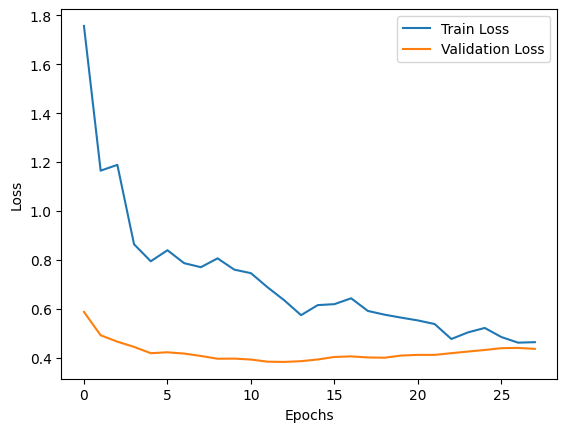

In [ ]:
import numpy as np

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error: {loss}')

# Predictions
y_pred = model.predict(X_test).flatten()

# Inverse transform the predictions and target to get back to the original scale
y_test_inverse = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inverse = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculate R² score
r2 = r2_score(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)

print(f'R² Score: {r2}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Plotting the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Cell 7: Plot Comparison and True vs. Predicted Values

6/6 [==============================] - 0s 4ms/step


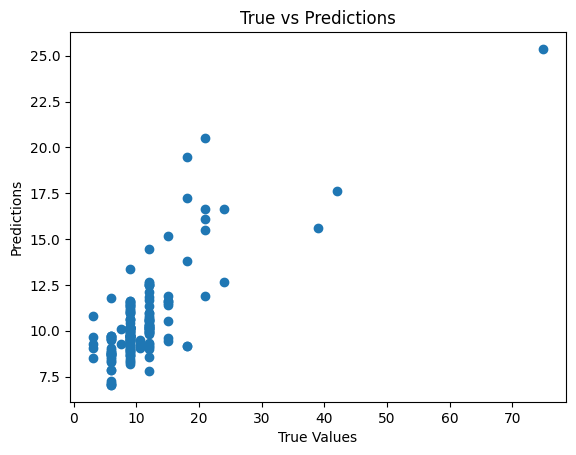

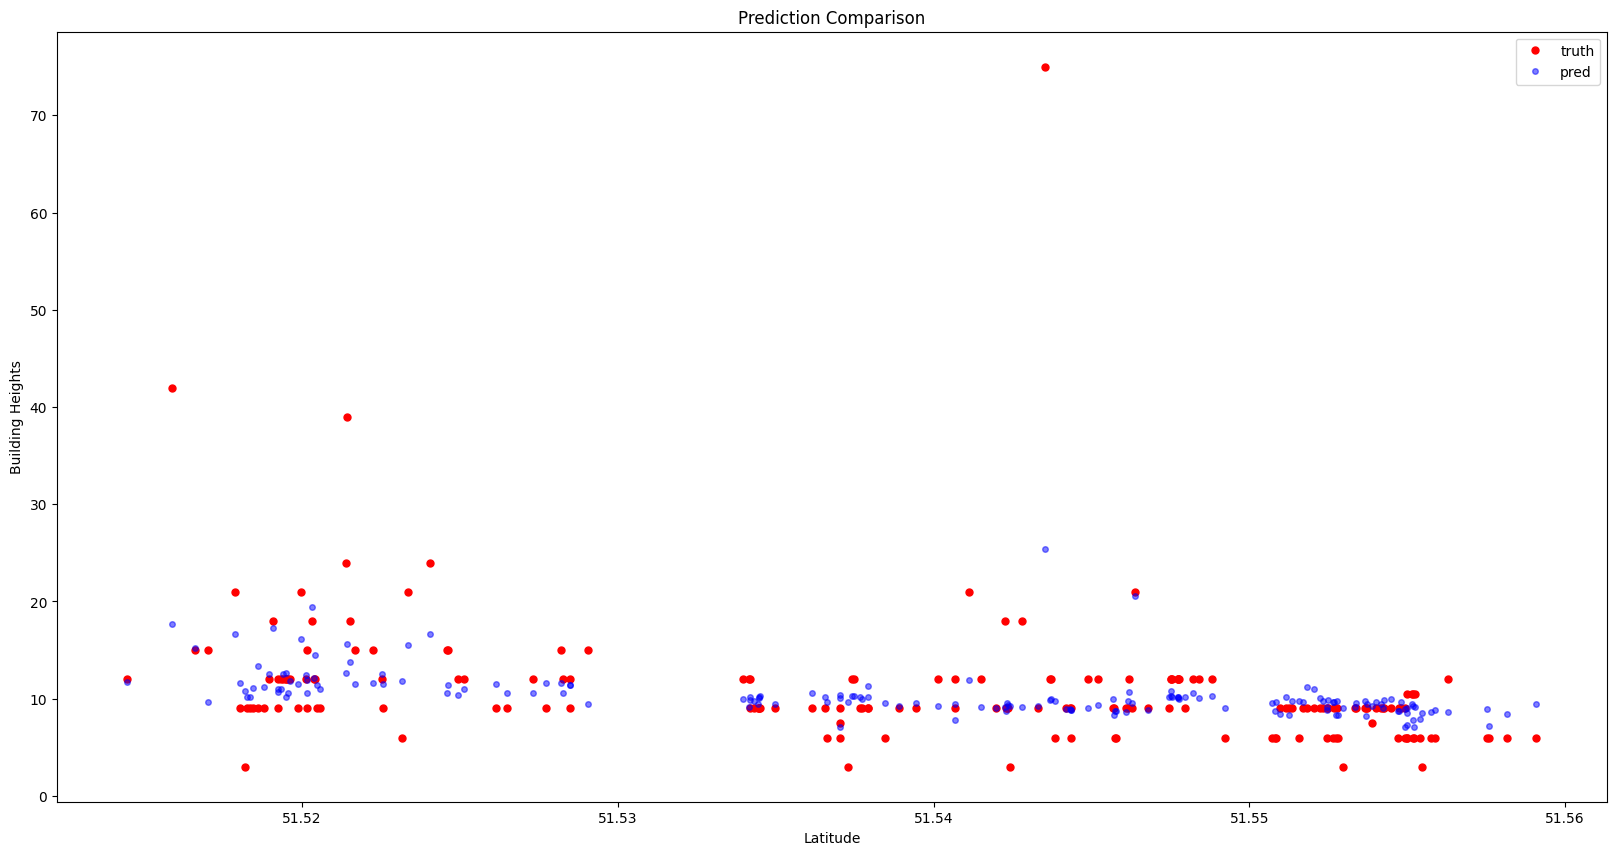

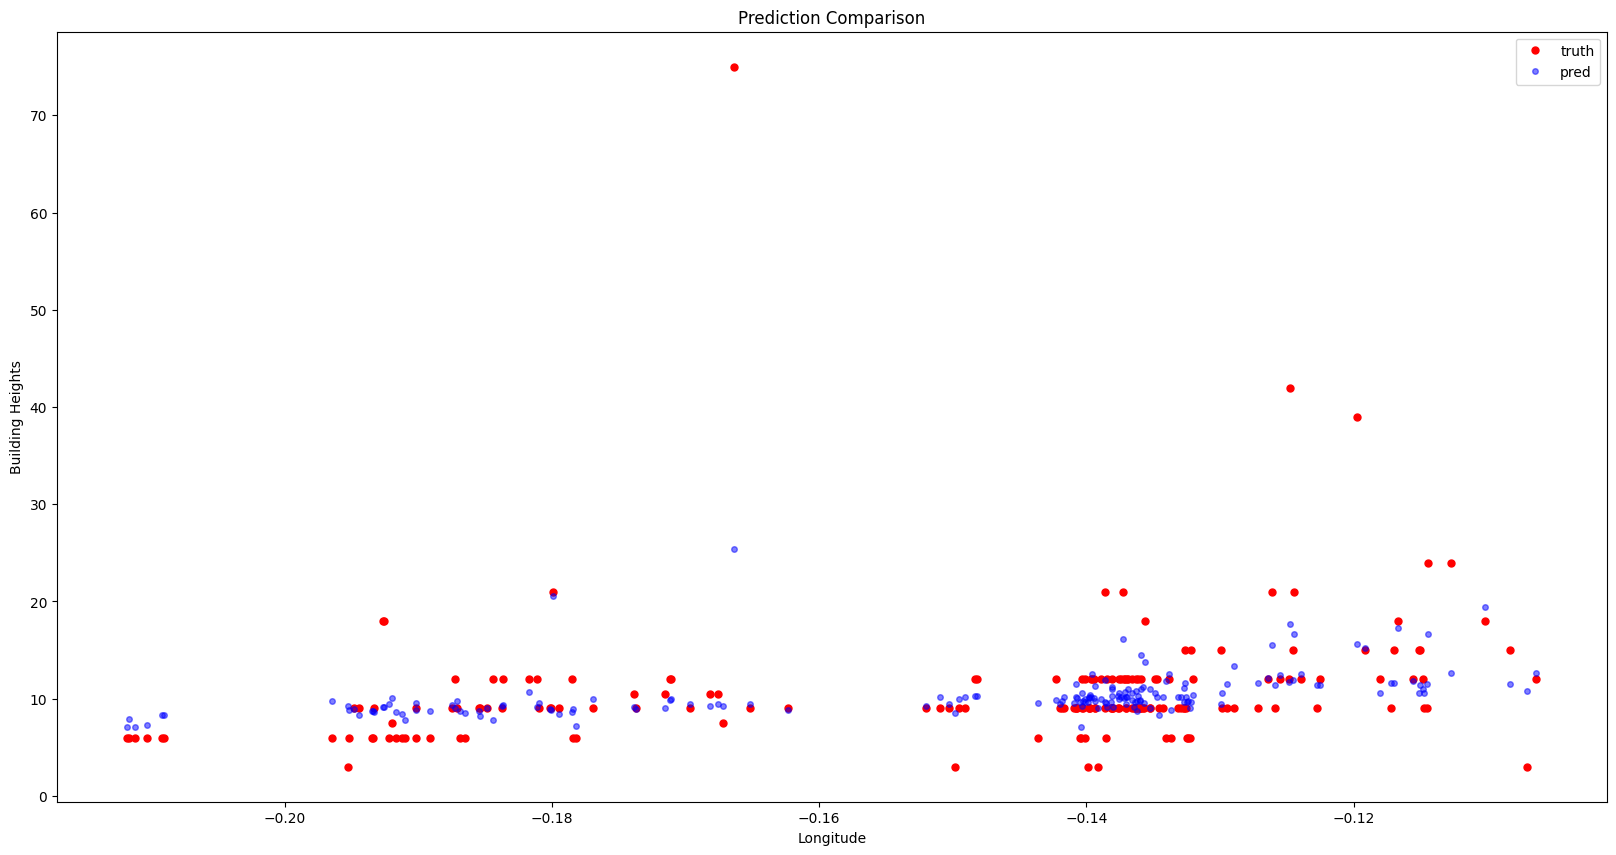

In [ ]:
def plot_comparison(x_val, pred, truth, xlab, ylab):
    fig, ax1 = plt.subplots()
    ax1.plot(x_val, truth, color='red', label='truth', linestyle='None', marker='o', markersize=5)
    ax1.plot(x_val, pred, color='blue', label='pred', linestyle='None', marker='o', markersize=4, alpha=0.5)

    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab)
    ax1.legend()
    fig.set_figheight(10)
    fig.set_figwidth(20)
    plt.title('Prediction Comparison')
    plt.show()

# Predictions
y_pred = model.predict(X_test).flatten()

# Inverse transform the predictions and target to get back to the original scale
y_test_inverse = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inverse = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Plot true vs predicted values
plt.scatter(y_test_inverse, y_pred_inverse)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predictions')
plt.show()

# Plot comparison for latitude and longitude
latitude_test = scaler_features.inverse_transform(X_test)[:, features.columns.get_loc('latitude')]
longitude_test = scaler_features.inverse_transform(X_test)[:, features.columns.get_loc('longitude')]

plot_comparison(latitude_test, y_pred_inverse, y_test_inverse, 'Latitude', 'Building Heights')
plot_comparison(longitude_test, y_pred_inverse, y_test_inverse, 'Longitude', 'Building Heights')


### Cell 8: Plot Prediction Error Distribution

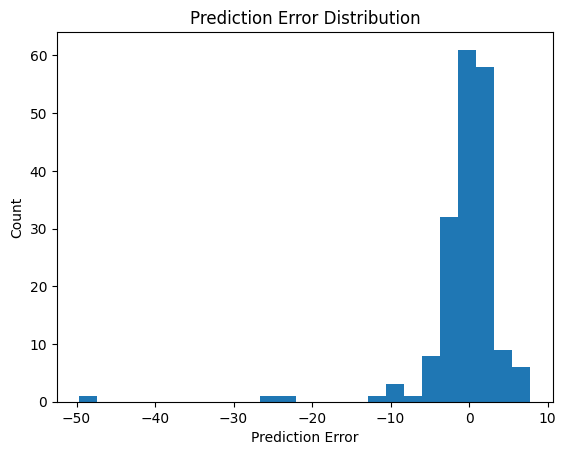

In [ ]:
# Calculate the prediction error
error = y_pred_inverse - y_test_inverse
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()


### Cell 9: Identify Outliers

In [ ]:
# Calculate the prediction error
error = y_pred_inverse - y_test_inverse

# Identify indices of outliers
negative_outliers_indices = np.where(error < -10)[0]
positive_outliers_indices = np.where(error > 10)[0]

# Filter the original data_for_corr DataFrame using these indices
negative_outliers = data_for_corr.iloc[negative_outliers_indices]
positive_outliers = data_for_corr.iloc[positive_outliers_indices]

print("Outliers with large negative errors:")
print(negative_outliers)

print("Outliers with large positive errors:")
print(positive_outliers)


Outliers with large negative errors:
     facade_area  Building_FootprintArea  camera_distance   latitude  \
34    144.240309               96.397044         0.000373  51.555141   
69   2006.957495              406.003779         0.000102  51.544963   
76    241.979442               94.829537         0.000182  51.553673   
102   260.793333               87.851150         0.000120  51.545005   

     longitude         brick   ceramic     glass         metal       painted  \
34   -0.211341  1.771932e-07  0.000011  0.000013  2.904521e-14  1.493951e-10   
69   -0.143632  8.692373e-04  0.004735  0.000073  1.525020e-10  1.360570e-06   
76   -0.136225  1.843868e-07  0.000027  0.000005  3.999006e-13  1.305409e-09   
102  -0.179802  4.700782e-05  0.000037  0.000146  3.226698e-10  1.313801e-07   

     ...  Category_commercial  Category_education  Category_hospitality  \
34   ...                  0.0                 0.0                   0.0   
69   ...                  0.0                 0.0  

# Cell 10: Train and Evaluate Model Without Outliers

Epoch 1/200
19/19 [==============================] - 3s 35ms/step - loss: 1.2447 - val_loss: 0.9812
Epoch 2/200
19/19 [==============================] - 0s 11ms/step - loss: 0.9792 - val_loss: 0.9283
Epoch 3/200
19/19 [==============================] - 0s 10ms/step - loss: 0.9814 - val_loss: 0.8865
Epoch 4/200
19/19 [==============================] - 0s 13ms/step - loss: 0.8252 - val_loss: 0.8628
Epoch 5/200
19/19 [==============================] - 0s 10ms/step - loss: 0.7069 - val_loss: 0.8455
Epoch 6/200
19/19 [==============================] - 0s 11ms/step - loss: 0.8386 - val_loss: 0.8288
Epoch 7/200
19/19 [==============================] - 0s 11ms/step - loss: 0.7444 - val_loss: 0.8223
Epoch 8/200
19/19 [==============================] - 0s 6ms/step - loss: 0.6861 - val_loss: 0.8086
Epoch 9/200
19/19 [==============================] - 0s 6ms/step - loss: 0.7048 - val_loss: 0.8005
Epoch 10/200
19/19 [==============================] - 0s 4ms/step - loss: 0.6579 - val_loss: 0.8093
Ep

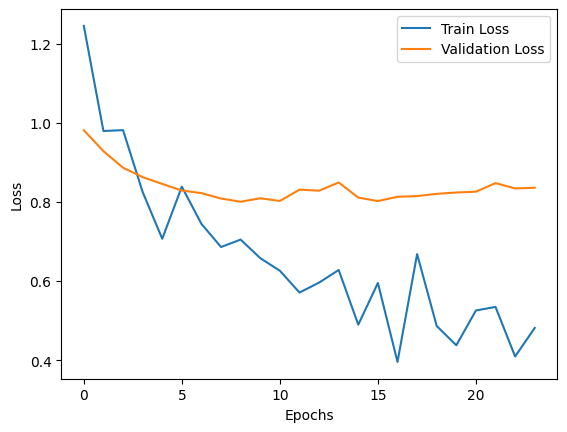

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Mask the outliers in the dataset
outlier_indices = np.concatenate((negative_outliers_indices, positive_outliers_indices))
mask = ~data_for_corr.index.isin(outlier_indices)

# Create new features and target without outliers
features_no_outliers = features[mask]
target_no_outliers = target[mask]

# Normalize features and target separately
scaler_features_no_outliers = StandardScaler()
features_normalized_no_outliers = scaler_features_no_outliers.fit_transform(features_no_outliers)

scaler_target_no_outliers = StandardScaler()
target_normalized_no_outliers = scaler_target_no_outliers.fit_transform(target_no_outliers.values.reshape(-1, 1)).flatten()

# Train-test split
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(features_normalized_no_outliers, target_normalized_no_outliers, test_size=0.2, random_state=42)

# Define the ANN model with adjusted dropout rates
model_no_outliers = Sequential()
n_cols_no_outliers = X_train_no_outliers.shape[1]

model_no_outliers.add(Dense(64, input_shape=(n_cols_no_outliers,), activation='relu'))
model_no_outliers.add(Dropout(0.3))  # Adjusted dropout rate
model_no_outliers.add(Dense(32, activation='relu'))
model_no_outliers.add(Dropout(0.3))  # Adjusted dropout rate
model_no_outliers.add(Dense(1, activation='linear'))

# Compile the model with a different learning rate
model_no_outliers.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping callback with increased patience
early_stopping_no_outliers = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with early stopping and increased epochs
history_no_outliers = model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers, epochs=200, validation_split=0.2, batch_size=32, callbacks=[early_stopping_no_outliers])

# Evaluate the model
loss_no_outliers = model_no_outliers.evaluate(X_test_no_outliers, y_test_no_outliers)
print(f'Mean Squared Error without outliers: {loss_no_outliers}')

# Predictions
y_pred_no_outliers = model_no_outliers.predict(X_test_no_outliers).flatten()

# Inverse transform the predictions and target to get back to the original scale
y_test_no_outliers_inverse = scaler_target_no_outliers.inverse_transform(y_test_no_outliers.reshape(-1, 1)).flatten()
y_pred_no_outliers_inverse = scaler_target_no_outliers.inverse_transform(y_pred_no_outliers.reshape(-1, 1)).flatten()

# Calculate R² score
r2 = r2_score(y_test_no_outliers_inverse, y_pred_no_outliers_inverse)
mae = mean_absolute_error(y_test_no_outliers_inverse, y_pred_no_outliers_inverse)
mse = mean_squared_error(y_test_no_outliers_inverse, y_pred_no_outliers_inverse)

print(f'R² Score without outliers: {r2}')
print(f'Mean Absolute Error without outliers: {mae}')
print(f'Mean Squared Error without outliers: {mse}')

# Plotting the training history
plt.plot(history_no_outliers.history['loss'], label='Train Loss')
plt.plot(history_no_outliers.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Cell 11: Hyperparameter Experimentation

Epoch 1/300
10/10 [==============================] - 3s 24ms/step - loss: 3.8404 - val_loss: 1.2286
Epoch 2/300
10/10 [==============================] - 0s 8ms/step - loss: 3.5285 - val_loss: 1.1971
Epoch 3/300
10/10 [==============================] - 0s 6ms/step - loss: 3.5589 - val_loss: 1.1705
Epoch 4/300
10/10 [==============================] - 0s 8ms/step - loss: 3.3452 - val_loss: 1.1819
Epoch 5/300
10/10 [==============================] - 0s 9ms/step - loss: 2.5814 - val_loss: 1.1671
Epoch 6/300
10/10 [==============================] - 0s 8ms/step - loss: 2.4571 - val_loss: 1.1666
Epoch 7/300
10/10 [==============================] - 0s 8ms/step - loss: 2.9584 - val_loss: 1.1695
Epoch 8/300
10/10 [==============================] - 0s 6ms/step - loss: 2.7467 - val_loss: 1.1691
Epoch 9/300
10/10 [==============================] - 0s 9ms/step - loss: 2.1804 - val_loss: 1.1603
Epoch 10/300
10/10 [==============================] - 0s 8ms/step - loss: 2.2395 - val_loss: 1.1427
Epoch 11

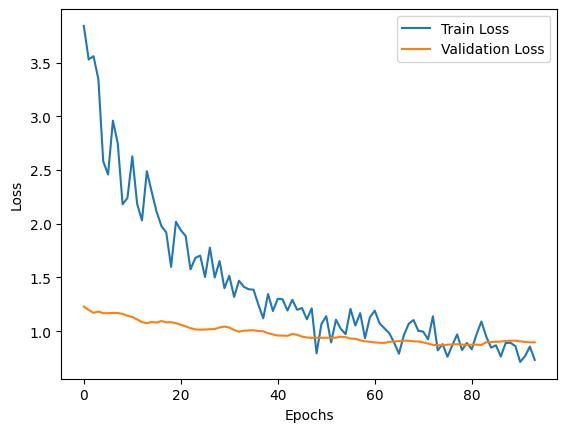

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

# Define a new ANN model with adjusted hyperparameters
def create_model(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='linear'))
    return model

# Create the model
model_exp = create_model(X_train_no_outliers.shape[1])

# Compile the model with a different learning rate
model_exp.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Early stopping callback with increased patience
early_stopping_exp = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping and increased epochs
history_exp = model_exp.fit(X_train_no_outliers, y_train_no_outliers, epochs=300, validation_split=0.2, batch_size=64, callbacks=[early_stopping_exp])

# Evaluate the model
loss_exp = model_exp.evaluate(X_test_no_outliers, y_test_no_outliers)
print(f'Mean Squared Error with new hyperparameters: {loss_exp}')

# Predictions
y_pred_exp = model_exp.predict(X_test_no_outliers).flatten()

# Inverse transform the predictions and target to get back to the original scale
y_test_no_outliers_inverse = scaler_target_no_outliers.inverse_transform(y_test_no_outliers.reshape(-1, 1)).flatten()
y_pred_exp_inverse = scaler_target_no_outliers.inverse_transform(y_pred_exp.reshape(-1, 1)).flatten()

# Calculate R² score
r2_exp = r2_score(y_test_no_outliers_inverse, y_pred_exp_inverse)
mae_exp = mean_absolute_error(y_test_no_outliers_inverse, y_pred_exp_inverse)
mse_exp = mean_squared_error(y_test_no_outliers_inverse, y_pred_exp_inverse)

print(f'R² Score with new hyperparameters: {r2_exp}')
print(f'Mean Absolute Error with new hyperparameters: {mae_exp}')
print(f'Mean Squared Error with new hyperparameters: {mse_exp}')

# Plotting the training history
plt.plot(history_exp.history['loss'], label='Train Loss')
plt.plot(history_exp.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Cell 12: Experiment with L2 Regularization

Epoch 1/300
10/10 [==============================] - 3s 119ms/step - loss: 2.7411 - val_loss: 2.6755
Epoch 2/300
10/10 [==============================] - 0s 26ms/step - loss: 2.6563 - val_loss: 2.5887
Epoch 3/300
10/10 [==============================] - 0s 26ms/step - loss: 2.4889 - val_loss: 2.5282
Epoch 4/300
10/10 [==============================] - 0s 25ms/step - loss: 2.4618 - val_loss: 2.4796
Epoch 5/300
10/10 [==============================] - 0s 26ms/step - loss: 2.3856 - val_loss: 2.4297
Epoch 6/300
10/10 [==============================] - 0s 27ms/step - loss: 2.2482 - val_loss: 2.3822
Epoch 7/300
10/10 [==============================] - 0s 20ms/step - loss: 2.2054 - val_loss: 2.3387
Epoch 8/300
10/10 [==============================] - 0s 25ms/step - loss: 2.1647 - val_loss: 2.2907
Epoch 9/300
10/10 [==============================] - 0s 29ms/step - loss: 2.1127 - val_loss: 2.2526
Epoch 10/300
10/10 [==============================] - 0s 18ms/step - loss: 2.1174 - val_loss: 2.215

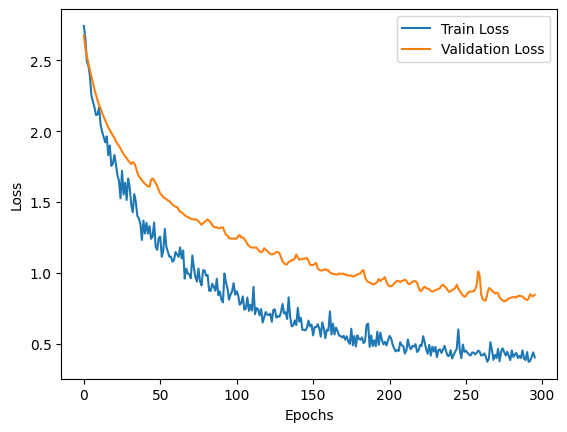

In [ ]:
from tensorflow.keras.regularizers import l2

# Define a new ANN model with L2 regularization
def create_model_with_l2(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_shape,), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    return model

# Create the model
model_l2 = create_model_with_l2(X_train_no_outliers.shape[1])

# Compile the model with a different learning rate
model_l2.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Early stopping callback with increased patience
early_stopping_l2 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping and increased epochs
history_l2 = model_l2.fit(X_train_no_outliers, y_train_no_outliers, epochs=300, validation_split=0.2, batch_size=64, callbacks=[early_stopping_l2])

# Evaluate the model
loss_l2 = model_l2.evaluate(X_test_no_outliers, y_test_no_outliers)
print(f'Mean Squared Error with L2 regularization: {loss_l2}')

# Predictions
y_pred_l2 = model_l2.predict(X_test_no_outliers).flatten()

# Inverse transform the predictions and target to get back to the original scale
y_test_no_outliers_inverse = scaler_target_no_outliers.inverse_transform(y_test_no_outliers.reshape(-1, 1)).flatten()
y_pred_l2_inverse = scaler_target_no_outliers.inverse_transform(y_pred_l2.reshape(-1, 1)).flatten()

# Calculate R² score
r2_l2 = r2_score(y_test_no_outliers_inverse, y_pred_l2_inverse)
mae_l2 = mean_absolute_error(y_test_no_outliers_inverse, y_pred_l2_inverse)
mse_l2 = mean_squared_error(y_test_no_outliers_inverse, y_pred_l2_inverse)

print(f'R² Score with L2 regularization: {r2_l2}')
print(f'Mean Absolute Error with L2 regularization: {mae_l2}')
print(f'Mean Squared Error with L2 regularization: {mse_l2}')

# Plotting the training history
plt.plot(history_l2.history['loss'], label='Train Loss')
plt.plot(history_l2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Calculate model accuracy as a percentage
model_accuracy_percentage = r2_l2 * 100
print(f'Model Accuracy: {model_accuracy_percentage:.2f}%')


Model Accuracy: 54.46%
